# Criminal Expungement - EDA


***
### Import Data [Test Case with 2019 Circuit Court]

In [ ]:
df_chargetype.show()
df = df_chargetype.toPandas()
df.head()

In [1]:
# Import libraries and set directory
import io
import os
import requests
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import addfips
import zipcodes
from uszipcode import Zipcode
import plotly.figure_factory as ff

In [2]:
# set your working directory (not needed if querying from DataSette)
os.chdir('/Users/amawest/Desktop/')

In [ ]:
# to query from DataSette
endpoint = "http://132.145.211.20:8001/criminal-court.csv?"
my_query = "select * from circuit_criminal_2019_anon_00"
r = requests.get(endpoint, params = {'sql': my_query})
data = io.StringIO(r.text)
df = pd.read_csv(data, sep=",")

In [ ]:
df.to_csv("circuit_19.csv", index=False)

In [3]:
# the data from DataSette 
#infile = "circuit_19.csv"

# uploading our own data (currently much larger)
infile = "circuit_criminal_2019.csv"

In [4]:
spark = SparkSession \
    .builder \
    .appName("Criminal Expungement") \
    .getOrCreate()

Exception: Java gateway process exited before sending its port number

In [ ]:
# Read in the data to a Spark dataframe
circuit = spark.read.csv(infile, inferSchema=True, header = True)

In [134]:
#circuit.printSchema()
print(circuit.count())
print(circuit.columns)

78121
['HearingDate', 'HearingResult', 'HearingJury', 'HearingPlea', 'HearingType', 'HearingRoom', 'fips', 'Filed', 'Commencedby', 'Locality', 'Sex', 'Race', 'Address', 'Charge', 'CodeSection', 'ChargeType', 'Class', 'OffenseDate', 'ArrestDate', 'DispositionCode', 'DispositionDate', 'ConcludedBy', 'AmendedCharge', 'AmendedCodeSection', 'AmendedChargeType', 'JailPenitentiary', 'ConcurrentConsecutive', 'LifeDeath', 'SentenceTime', 'SentenceSuspended', 'OperatorLicenseSuspensionTime', 'FineAmount', 'Costs', 'FinesCostPaid', 'ProgramType', 'ProbationType', 'ProbationTime', 'ProbationStarts', 'CourtDMVSurrender', 'DriverImprovementClinic', 'DrivingRestrictions', 'RestrictionEffectiveDate', 'RestrictionEndDate', 'VAAlcoholSafetyAction', 'RestitutionPaid', 'RestitutionAmount', 'Military', 'TrafficFatality', 'AppealedDate', 'person_id']


In [135]:
# create Spark SQL Instance
circuit.createOrReplaceTempView("court_data")

In [136]:
# just checking to make sure the instance worked 
sqlDF = spark.sql('SELECT Sex, Race, Charge FROM court_data')
sqlDF.show(1, False)

+----+-----+-------------------------+
|Sex |Race |Charge                   |
+----+-----+-------------------------+
|Male|White|VIOL PROBATION ON FEL OFF|
+----+-----+-------------------------+
only showing top 1 row



***
### Exploratory SQL + Read in Census Data

In [140]:
sqlDF = spark.sql('SELECT Race, count(*) as Count FROM court_data GROUP BY Race')
sqlDF.show(10, False)

+----------------------------------------+-----+
|Race                                    |Count|
+----------------------------------------+-----+
|null                                    |276  |
|Unknown                                 |3    |
|Other (Includes Not Applicable, Unknown)|885  |
|American Indian Or Alaskan Native       |38   |
|White                                   |43890|
|Asian Or Pacific Islander               |260  |
|Black                                   |32401|
|Hispanic                                |368  |
+----------------------------------------+-----+



In [142]:
sqlDF = spark.sql('SELECT Race, ChargeType, count(ChargeType) as Count FROM court_data \
                   GROUP BY Race, ChargeType ORDER BY Count DESC')
sqlDF.show(100, False)

+----------------------------------------+---------------------------------------+-----+
|Race                                    |ChargeType                             |Count|
+----------------------------------------+---------------------------------------+-----+
|White                                   |Felony                                 |31894|
|Black                                   |Felony                                 |22238|
|White                                   |Misdemeanor                            |9867 |
|Black                                   |Misdemeanor                            |7470 |
|Black                                   |Other (Animal Violations, Bond Appeals)|1637 |
|White                                   |Other (Animal Violations, Bond Appeals)|1279 |
|Black                                   |Infraction                             |928  |
|White                                   |Infraction                             |705  |
|Other (Includes Not 

#### How does this compare against the percentage of each race within the state in 2019?
- Source: U.S. 2019 Census, https://www.census.gov/quickfacts/fact/table/VA/PST045219

In [17]:
infile = '2019 Virginia Population.csv'
spark = SparkSession \
    .builder \
    .appName("Population") \
    .getOrCreate()
population = spark.read.csv(infile, inferSchema=True, header = True)

# Drop Fact Note and Value Note columns
population = population.drop('Fact Note', 'Value Note for Virginia')

In [18]:
population.show(16, False)

+-------------------------------------------------------------------------------------+---------+
|Fact                                                                                 |Virginia |
+-------------------------------------------------------------------------------------+---------+
|Population estimates, July 1, 2019,  (V2019)                                         |8,535,519|
|Population estimates base, April 1, 2010,  (V2019)                                   |8,001,049|
|Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)|6.7%     |
|Population, Census, April 1, 2010                                                    |8,001,024|
|Persons under 5 years, percent                                                       |5.9%     |
|Persons under 18 years, percent                                                      |21.8%    |
|Persons 65 years and over, percent                                                   |15.9%    |
|Female persons, per

In [19]:
# mental check that population percentages add up to ~100
# note: may want to investigate why it's 101.6
61.2+19.9+9.8+0.5+6.9+0.1+3.2

101.6

In [20]:
# the percentages make the last column a string, so I'm just manually rewriting them
# in the future it would be best to read it straight from the census data 
pop_2019 = 8535519
pop_white = 61.2
pop_black = 19.9
pop_hispanic = 9.8
pop_native_amer = 0.5
pop_asian_pacific = 7.0
pop_two_or_more = 3.2

# Create a Spark dataframe that only has the information we truly need based on the Census data we have found
pop = spark.createDataFrame(
    [('White', round(pop_2019*(pop_white/100),2)),  # create your data here, be consistent in the types.
     ('Black', round(pop_2019*(pop_black/100),2)),
     ('Hispanic', round(pop_2019*(pop_hispanic/100),2)),
     ('American Indian Or Alaskan Native', round(pop_2019*(pop_native_amer/100),2)),
     ('Asian Or Pacific Islander', round(pop_2019*(pop_asian_pacific/100),2)),
     ('Two or More Races', round(pop_2019*(pop_two_or_more/100),2)),],
    ["Race", "Population_2019"]  # add your column names here
)
pop.createOrReplaceTempView("pop_data")

In [21]:
pop.show(10, False)

+---------------------------------+---------------+
|Race                             |Population_2019|
+---------------------------------+---------------+
|White                            |5223737.63     |
|Black                            |1698568.28     |
|Hispanic                         |836480.86      |
|American Indian Or Alaskan Native|42677.6        |
|Asian Or Pacific Islander        |597486.33      |
|Two or More Races                |273136.61      |
+---------------------------------+---------------+



In [22]:
sqlDF = spark.sql('SELECT c.Race, c.ChargeType, count(c.ChargeType)as Count, \
                   max(p.Population_2019) as Population, ROUND((count(c.ChargeType)/max(p.Population_2019))*100,5) as Percent_Pop_For_Race \
                   FROM court_data c \
                   INNER JOIN pop_data p ON p.Race = c.Race \
                   GROUP BY c.Race, c.ChargeType ORDER BY c.ChargeType')
sqlDF.show(100, False)

+---------------------------------+---------------------------------------+-----+----------+--------------------+
|Race                             |ChargeType                             |Count|Population|Percent_Pop_For_Race|
+---------------------------------+---------------------------------------+-----+----------+--------------------+
|Hispanic                         |Civil                                  |1    |836480.86 |1.2E-4              |
|White                            |Civil                                  |145  |5223737.63|0.00278             |
|Black                            |Civil                                  |128  |1698568.28|0.00754             |
|Hispanic                         |Felony                                 |221  |836480.86 |0.02642             |
|Asian Or Pacific Islander        |Felony                                 |179  |597486.33 |0.02996             |
|American Indian Or Alaskan Native|Felony                                 |14   |42677.6

### Question 1 - *Find from the census the total population of Virginia by racial group and see if racial groups in the court data are over/under represented*

In [23]:
# broken down by charge and race
sqlDF = spark.sql('SELECT c.Race, c.ChargeType, count(c.ChargeType) as Count, \
                   max(p.Population_2019) as Population, ROUND((count(c.ChargeType)/max(p.Population_2019))*100,5) as Percent_Pop_By_Race \
                   FROM court_data c \
                   INNER JOIN pop_data p ON p.Race = c.Race \
                   GROUP BY c.Race, c.ChargeType ORDER BY c.ChargeType')
sqlDF.show(100, False)

+---------------------------------+---------------------------------------+-----+----------+-------------------+
|Race                             |ChargeType                             |Count|Population|Percent_Pop_By_Race|
+---------------------------------+---------------------------------------+-----+----------+-------------------+
|Hispanic                         |Civil                                  |1    |836480.86 |1.2E-4             |
|Black                            |Civil                                  |128  |1698568.28|0.00754            |
|White                            |Civil                                  |145  |5223737.63|0.00278            |
|White                            |Felony                                 |31894|5223737.63|0.61056            |
|Hispanic                         |Felony                                 |221  |836480.86 |0.02642            |
|American Indian Or Alaskan Native|Felony                                 |14   |42677.6   |0.03

In [24]:
# broken down by race only (all charges)
# note that the current output is working off the 1,000 from DataSette so the percentages are incredibly small 
sqlDF = spark.sql('SELECT c.Race, \
                   max(p.Population_2019) as Population, \
                   ROUND((count(c.Race)/max(p.Population_2019))*100,5) as Percent_Pop_Charged_Crime_By_Race \
                   FROM court_data c \
                   INNER JOIN pop_data p ON p.Race = c.Race \
                   GROUP BY c.Race')
sqlDF.show(truncate=False)

+---------------------------------+----------+---------------------------------+
|Race                             |Population|Percent_Pop_Charged_Crime_By_Race|
+---------------------------------+----------+---------------------------------+
|American Indian Or Alaskan Native|42677.6   |0.08904                          |
|White                            |5223737.63|0.8402                           |
|Asian Or Pacific Islander        |597486.33 |0.04352                          |
|Black                            |1698568.28|1.90755                          |
|Hispanic                         |836480.86 |0.04399                          |
+---------------------------------+----------+---------------------------------+



It seems that the black population has the highest percentage of it's population who have been charged with a crime (whether deserving the sentence or not) at 1.907%, with second being white people (0.84%), then American Indians, Hispanic and Asian populations in decreasing order.

### Question 2 - *Create a map of racial disparity by area, and we can show changes in that map over time.*
- Note that we're switching back to a pandas dataframe for data preprocessing and graphing in plotly


Sources
- https://docs.astraea.earth/hc/en-us/articles/360043452452-Read-a-Shapefile-into-Spark-DataFrame 
- https://plotly.com/python/choropleth-maps/


In [43]:
# (restart the kernel for the changes to take effect)
# !pip install plotly-geo
# !pip install geopandas==0.3.0
# !pip install pyshp==1.2.10
# !pip install shapely==1.6.3
circuit = pd.read_csv("circuit_criminal_2019.csv")

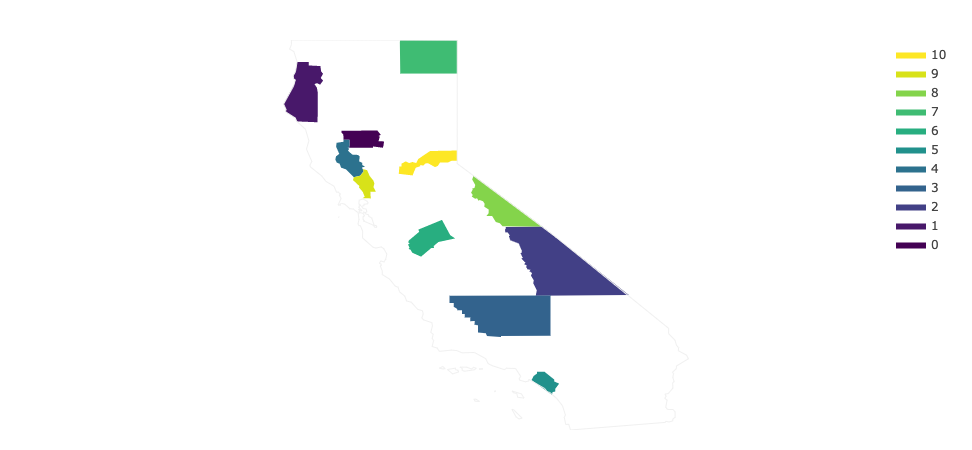

In [71]:
# toy example to make sure geospatial viz works (it can be a bit testy)
import plotly.figure_factory as ff
fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))
fig = ff.create_choropleth(fips=fips, values=values, scope=['CA'])
fig.layout.template = None
fig.show()

In [72]:
# based on the 3 types of location info provided, zipcode is our most granular option
print(circuit.fips.unique()[:5])
print(circuit.Locality.unique()[:1])
print(circuit.Address.unique()[:1])

[ 91  99  93 760  97]
['COMMONWEALTH OF VA']
['MONTEREY, VA 24465']


In [73]:
# this function matches county to zip
af = addfips.AddFIPS()

# test that it works based on 2 zipcodes --> counties I know
info = zipcodes.matching('22901') # my current residence (VA)
print(info[0]['county'])
info = zipcodes.matching('49046') # my hometown (MI)
print(info[0]['county'])

Albemarle County
Barry County


In [74]:
# step 3: we need zipcodes, we we'll need to extract them from the addresses
circuit[['city_state', 'zip']] = circuit.Address.str.rsplit(" ", n=1, expand=True,)
circuit_zips = circuit[circuit['zip'].notnull()]
# note: it doesn't have this one county in the system, it seems

# a few zip codes create an error because they don't have a corresponding county,
# this should be rewritten so that the loop happening a few lines later learns
# to just past over these zips to avoid breaking (and for when we add data later)
circuit_zips = circuit_zips[~circuit_zips['zip'].str.contains('VA-2435')]  # there's a messed up zip in row 50k
circuit_zips = circuit_zips[circuit_zips['zip'].str.contains('2')]

In [75]:
print(circuit_zips.zip.unique()[:1])
print(circuit_zips.zip.count())

['24465']
73025


In [76]:
circuit_zips['county'] = 0
circuit_zips['state']  = 'Virginia'
circuit_zips[3683:3684]

,HearingDate,HearingResult,HearingJury,HearingPlea,HearingType,HearingRoom,fips,Filed,Commencedby,Locality,...,RestitutionPaid,RestitutionAmount,Military,TrafficFatality,AppealedDate,person_id,city_state,zip,county,state
3820,2020-09-02,NaN,NaN,NaN,Deferred Disposition,311,760,2019-03-07,Indictment,COMMONWEALTH OF VA,...,NaN,NaN,NaN,NaN,NaN,1.640300e+14,"RICHMOND, VA",23223,0,Virginia


In [77]:
# add in the county names 
for i in range(len(circuit_zips)):
    info = zipcodes.matching(list(circuit_zips['zip'])[i])
    if info == []:
        pass
    else: 
        circuit_zips['county'][i] = info[0]['county']

In [78]:
list(circuit_zips['zip'])[i]

'24105'

In [79]:
circuit_zips.head() # scroll to the end to see that adding county has worked 

,HearingDate,HearingResult,HearingJury,HearingPlea,HearingType,HearingRoom,fips,Filed,Commencedby,Locality,...,RestitutionPaid,RestitutionAmount,Military,TrafficFatality,AppealedDate,person_id,city_state,zip,county,state
0,2019-12-17,Revoked - Sentence/Probation,NaN,NaN,Revocation,NaN,91,2019-10-23,Other,COMMONWEALTH OF VA,...,NaN,0.0,NaN,NaN,NaN,9.318000e+13,"MONTEREY, VA",24465,Highland County,Virginia
1,2019-12-17,Sentenced,NaN,NaN,Trial,NaN,91,2019-09-16,Direct Indictment,COMMONWEALTH OF VA,...,NaN,250.0,NaN,f,NaN,3.405000e+13,"PETERSBURG, WV",26847,Grant County,Virginia
2,2019-10-30,Granted,NaN,NaN,Review,NaN,91,2009-07-08,Indictment,COMMONWEALTH OF VA,...,NaN,NaN,NaN,NaN,NaN,1.531100e+14,"BLUE GRASS, VA",24413,Highland County,Virginia
3,2019-10-30,NaN,NaN,NaN,Review,NaN,91,2009-07-08,Indictment,COMMONWEALTH OF VA,...,NaN,NaN,NaN,NaN,NaN,1.531100e+14,"BLUE GRASS, VA",24413,Highland County,Virginia
4,2019-10-30,Continued Generally,NaN,NaN,Show Cause,NaN,91,2016-10-31,General District Court Appeal,COMMONWEALTH OF VA,...,NaN,NaN,NaN,f,NaN,1.230100e+14,"BLUE GRASS, VA",24413,Highland County,Virginia


In [ ]:
# add in the county fips values (what we'll actually be using)
circuit_zips['county_fips'] = 0
key_list = ["state", "county"]
a_dict = dict.fromkeys(key_list)
a_dict['state'] = 'Virginia'

## FIXME: This seems to be the issue here (stopping early)

In [32]:
for i in range(len(circuit_zips)):
    a_dict['county'] = (list(circuit_zips['county'])[i])
    if a_dict['county'] == 0:
        pass
    else:
        county_fips = af.add_county_fips(a_dict, county_field="county", state_field="state")
        circuit_zips['county_fips'][i] = county_fips['fips']

In [50]:
circuit_zips = circuit_zips[circuit_zips['county_fips'].notnull()]
circuit_zips['county_fips'].unique()
len(circuit_zips)

24

In [34]:
circuit_zips['county_fips'] = circuit_zips['county_fips'].apply(pd.to_numeric)
circuit_zips = circuit_zips[circuit_zips['county_fips'] != 0]
county_fips_only = circuit_zips.groupby(['county_fips']).size()
print(len(circuit_zips.county_fips.unique()))

7


In [35]:
x = circuit_zips.groupby(['county_fips', 'Race']).size().reset_index()
x.rename(columns = {0: 'values'}, inplace = True)
x['Count'] = x['values']

In [36]:
x_just_white = x[x['Race'] == 'White']
x_just_white = x_just_white.groupby(['county_fips']).size().reset_index()

In [37]:
x = x.groupby(['county_fips']).size().reset_index()

In [38]:
x.rename(columns = {0: 'Total'}, inplace = True)
x_just_white.rename(columns = {0: 'White'}, inplace = True)

In [39]:
horizontal_stack = pd.concat([x_just_white, x], axis=1)

In [40]:
final_geo = pd.merge(x, x_just_white,on='county_fips')
final_geo['Percent_White'] = final_geo['White'] / final_geo['Total']
final_geo['Percent_Minority'] = 1 - (final_geo['White'] / final_geo['Total'])

In [41]:
final_geo

,county_fips,Total,White,Percent_White,Percent_Minority
0,51005.0,1,1,1.0,0.0
1,51015.0,1,1,1.0,0.0
2,51017.0,1,1,1.0,0.0
3,51091.0,2,1,0.5,0.5
4,51165.0,1,1,1.0,0.0
5,51810.0,1,1,1.0,0.0


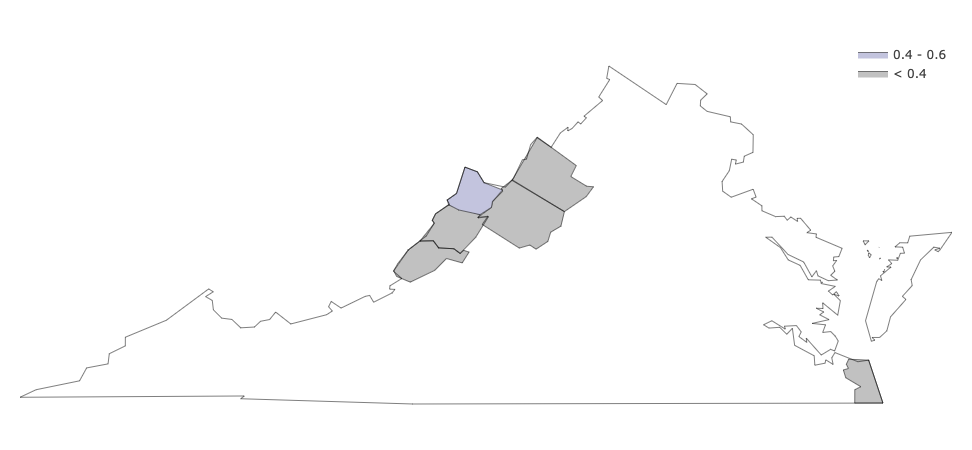

In [42]:
fips = list(final_geo.county_fips)      
values = list(final_geo.Percent_Minority)
colorscale = [
    'rgb(193, 193, 193)',
    'rgb(195, 196, 222)',
    'rgb(141,144,200)',
    'rgb(65, 53, 132)']
fig = ff.create_choropleth(fips=fips, 
                           values=values, 
                           scope=['VA'],
                           show_hover = True,
                           binning_endpoints = [.4, .6, .9],
                           county_outline={'color': 'black', 'width': 0.5},
                           state_outline={'color': 'black', 'width': 0.5},
                           colorscale=colorscale)
fig.layout.template = None
fig.show()

### Question 3 - *What criminal charges produce the worst racial disparities?*

In [46]:
infile = "circuit_criminal_2019.csv"
circuit = spark.read.csv(infile, inferSchema=True, header = True)
circuit.createOrReplaceTempView('df')

In [47]:
df_strat = spark.sql(
'''
SELECT df.Charge, df.Race, count(Charge) AS RChargeCount, TChargeCount FROM df
JOIN (SELECT Charge AS TCharge, count(Charge) as TChargeCount FROM df
GROUP BY Charge) T on TCharge = Charge
GROUP BY Charge, Race, TChargeCount
'''
)

In [48]:
df_strat.count()

14899

In [49]:
charge_list_total_over_100 = df_strat.withColumn('Percentage', df_strat.RChargeCount*100/df_strat.TChargeCount)\
    .select('Charge','Race','Percentage','TChargeCount')\
    .withColumnRenamed('TChargeCount','TotalNumberOfCharges').filter(df_strat.TChargeCount > 1000)
charge_list_total_over_100.orderBy(charge_list_total_over_100.Percentage.desc()).show(30,truncate=False)

+----------------------------+----------------------------------------+--------------------+--------------------+
|Charge                      |Race                                    |Percentage          |TotalNumberOfCharges|
+----------------------------+----------------------------------------+--------------------+--------------------+
|POSS.OF CONTROLLED SUBSTANCE|White                                   |74.80647431386348   |1421                |
|BOND APPEAL                 |White                                   |60.80992815153495   |1531                |
|PROBATION VIOLATION         |White                                   |59.694232105628906  |1439                |
|GRAND LARCENY               |White                                   |57.9624134520277    |1011                |
|VIOL PROBATION ON FEL OFF   |White                                   |55.860702151755376  |7064                |
|VIOL PROBATION ON FEL OFF   |Black                                   |43.20498301245753

### Question 4 - *Count the number of black people charged with felonies vs. white people charged with misdemeanors for the same offense by year*
- FIXME - Add additional years beyond 2019....

In [118]:
df_chargetype = spark.sql(
'''
SELECT ChargeType, df.Race, count(ChargeType) AS RCount, TCount FROM df
INNER JOIN (
    SELECT Race, count(Race) as TCount FROM df
    GROUP BY Race) c ON c.Race = df.Race
WHERE (ChargeType = 'Felony' OR ChargeType = 'Misdemeanor') AND (df.Race = 'White' OR df.Race = 'Black')
GROUP BY ChargeType, df.Race, TCount
'''
)
df_chargetype = df_chargetype.withColumn('Percentage',df_chargetype.RCount*100/df_chargetype.TCount).select('ChargeType','Race','Percentage','TCount')

In [119]:
df_chargetype.show()

+-----------+-----+------------------+------+
| ChargeType| Race|        Percentage|TCount|
+-----------+-----+------------------+------+
|Misdemeanor|Black| 23.05484398629672| 32401|
|     Felony|White|  72.6680337206653| 43890|
|Misdemeanor|White|22.481203007518797| 43890|
|     Felony|Black| 68.63368414555106| 32401|
+-----------+-----+------------------+------+



In [120]:
df = df_chargetype.toPandas()
df.head()

,ChargeType,Race,Percentage,TCount
0,Misdemeanor,Black,23.054844,32401
1,Felony,White,72.668034,43890
2,Misdemeanor,White,22.481203,43890
3,Felony,Black,68.633684,32401


Text(0.5, 1.0, 'Disposition Code By Race')

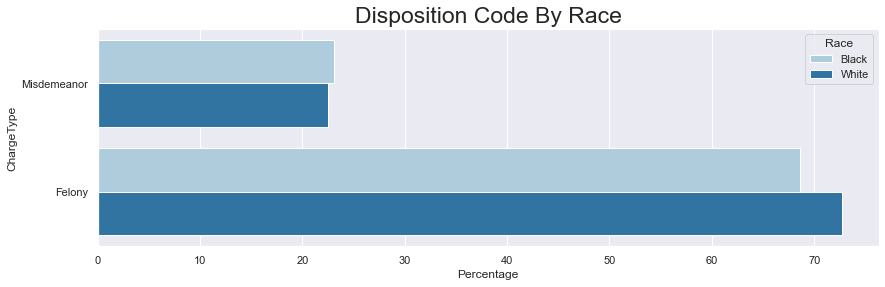

In [126]:
sns.set(rc={'figure.figsize':(14,4)})
sns.set(style="darkgrid")
sns.set_palette("Paired")
ax = sns.barplot(y="ChargeType",
                   x="Percentage",
                   data=df, 
                   hue="Race")
ax.set_title('Disposition Code By Race', fontsize = 23)
# https://seaborn.pydata.org/generated/seaborn.countplot.html

### Question 5 - *Count the number of black people convicted of felonies vs. white people convicted of misdemeanors (or not convicted at all) for the same offense by year*

- We use DispositionCode to track convictions
- FIXME - Add additional years beyond 2019....

In [53]:
DispositionCode_types = ['Guilty', 'Dismissed', 'Sentence/Probation Revoked',
                         'Nolle Prosequi', 'Resolved', 'Appeal Withdrawn',
                         'Not Guilty/Acquitted', 'Not True Bill', 'Remanded',
                         'No Indictment Presented', 'Mistrial',
                         'Not Guilty By Reason Of Insanity']

In [42]:
circuit.select("DispositionCode")

DataFrame[DispositionCode: string]

In [81]:
df_chargetype = spark.sql(
'''
SELECT DispositionCode, df.Race, count(DispositionCode) AS RCount, Total FROM df
INNER JOIN (
    SELECT Race, count(Race) as Total FROM df
    GROUP BY Race) c ON c.Race = df.Race
WHERE (DispositionCode = 'Guilty'            OR   DispositionCode = 'Not Guilty/Acquitted'              OR
       DispositionCode = 'Dismissed'         OR   DispositionCode = 'Resolved'                          OR
       DispositionCode = 'Nolle Prosequi'    OR   DispositionCode = 'Remanded'                          OR
       DispositionCode = 'Not True Bill'     OR   DispositionCode = 'Sentence/Probation Revoked'        OR
       DispositionCode = 'Mistrial'          OR   DispositionCode = 'Not Guilty By Reason Of Insanity'  OR
       DispositionCode = 'Appeal Withdrawn'  OR   DispositionCode = 'No Indictment Presented' ) 
AND (df.Race = 'White' OR df.Race = 'Black')
GROUP BY DispositionCode, df.Race, Total
ORDER BY DispositionCode
'''
)
df_chargetype = df_chargetype.withColumn('Percentage',df_chargetype.RCount*100/df_chargetype.Total).select('DispositionCode','Race','Percentage','Total')



In [82]:
df_chargetype.show(truncate=False)

+--------------------------------+-----+-------------------+-----+
|DispositionCode                 |Race |Percentage         |Total|
+--------------------------------+-----+-------------------+-----+
|Appeal Withdrawn                |Black|1.438227215209407  |32401|
|Appeal Withdrawn                |White|0.9660514923672818 |43890|
|Dismissed                       |White|8.056504898610163  |43890|
|Dismissed                       |Black|8.141724020863554  |32401|
|Guilty                          |White|34.04192298929141  |43890|
|Guilty                          |Black|34.77053177371069  |32401|
|Mistrial                        |Black|0.27468288015801984|32401|
|Mistrial                        |White|0.07063112326270221|43890|
|No Indictment Presented         |Black|0.16974784728866393|32401|
|No Indictment Presented         |White|0.22556390977443608|43890|
|Nolle Prosequi                  |Black|17.959322243140644 |32401|
|Nolle Prosequi                  |White|21.61995898838004  |43

In [94]:
df = df_chargetype.toPandas()
df.head()

,DispositionCode,Race,Percentage,Total
0,Appeal Withdrawn,Black,1.438227,32401
1,Appeal Withdrawn,White,0.966051,43890
2,Dismissed,White,8.056505,43890
3,Dismissed,Black,8.141724,32401
4,Guilty,Black,34.770532,32401


Text(0.5, 1.0, 'Disposition Code By Race')

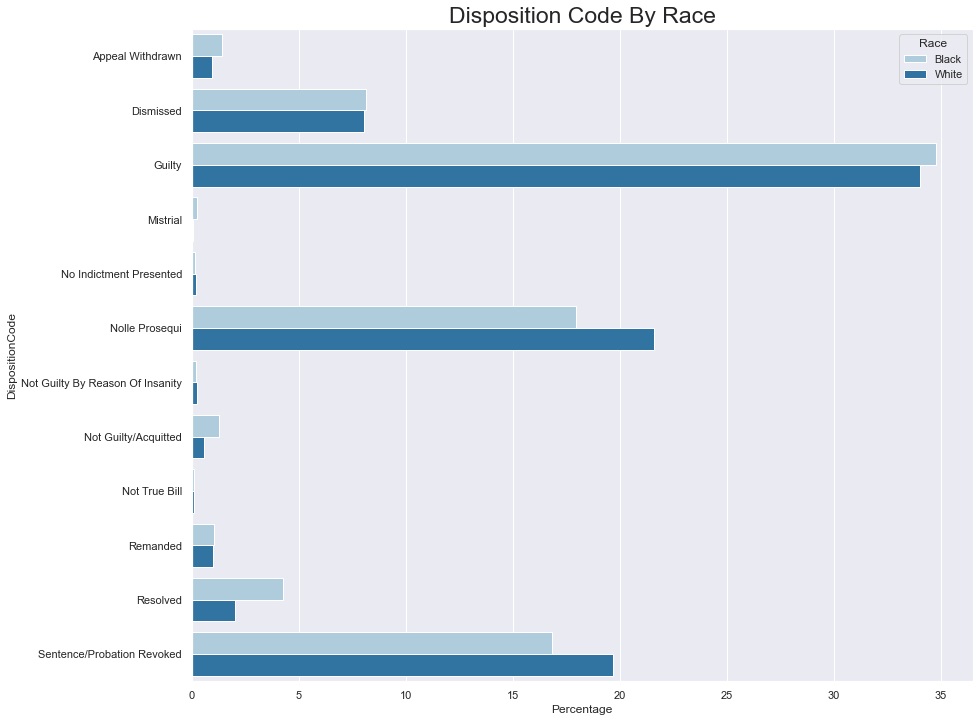

In [117]:
sns.set(rc={'figure.figsize':(14,12)})
sns.set(style="darkgrid")
sns.set_palette("Paired")
ax = sns.barplot(y="DispositionCode",
                   x="Percentage",
                   data=df, 
                   hue="Race")
ax.set_title('Disposition Code By Race', fontsize = 23)

### Question 6 - *What are the most common offenses in the VA court system*

In [18]:
sqlDF = spark.sql('SELECT Charge, count(Charge) as Count FROM court_data \
                   GROUP BY Charge ORDER BY Count DESC')
sqlDF.show(30, False)
# Q: how did they deal with multiple convictions?

+------------------------------+-----+
|Charge                        |Count|
+------------------------------+-----+
|VIOL PROBATION ON FEL OFF     |7064 |
|BOND APPEAL                   |1531 |
|PROBATION VIOLATION           |1439 |
|POSS.OF CONTROLLED SUBSTANCE  |1421 |
|GRAND LARCENY                 |1011 |
|VIOL PROBATION OF MISD OFF    |875  |
|SHOW CAUSE REVOCATION         |820  |
|DRUGS: POSSESS SCH I OR II    |771  |
|OBTAIN MONEY FALSE PRET >=$200|717  |
|CAPIAS TO SHOW CAUSE          |699  |
|FORGERY                       |684  |
|MANUF/ETC CONTROLLED SUBSTANCE|654  |
|BAIL-APPEAL CONDITN OF RELEASE|569  |
|POSS SCH I/II CONTR SUBSTANCE |558  |
|UTTERING                      |532  |
|MALICIOUS WOUNDING            |517  |
|FAIL TO APPEAR; CONTEMPT      |494  |
|POSS SCH I OR II CONT SUB     |424  |
|POSSESSION OF MARIJUANA       |420  |
|FAIL TO APPEAR, FELONY OFFENSE|418  |
|DRIV UNDER REVO/SUSPENSION    |408  |
|GRAND LARCENY/SC              |404  |
|ASSAULT & BATTERY-FAM ME

### Question 7 - *Make a bar plot of the 20 most frequent codes*
- Note that we're transitioning back to the pandas dataframe (df) that we created to graph with seaborn

In [19]:
circuit = pd.read_csv("circuit_criminal_2019.csv")

In [20]:
top_20_charges = list(dict(circuit.Charge.value_counts(dropna=False).head(20)).keys())
circuit = circuit[circuit['Charge'].isin(top_20_charges)]
circuit = circuit[circuit.Race.notnull()] # the graph breaks if there's empty values
circuit.Race.value_counts(dropna=False)   # this is to check for counts/that nulls are gone

White                                       13215
Black                                        8061
Other (Includes Not Applicable, Unknown)      126
Hispanic                                       73
Asian Or Pacific Islander                      60
Unknown                                         3
American Indian Or Alaskan Native               3
Name: Race, dtype: int64

Text(0.5, 1.0, 'Top 20 Charges')

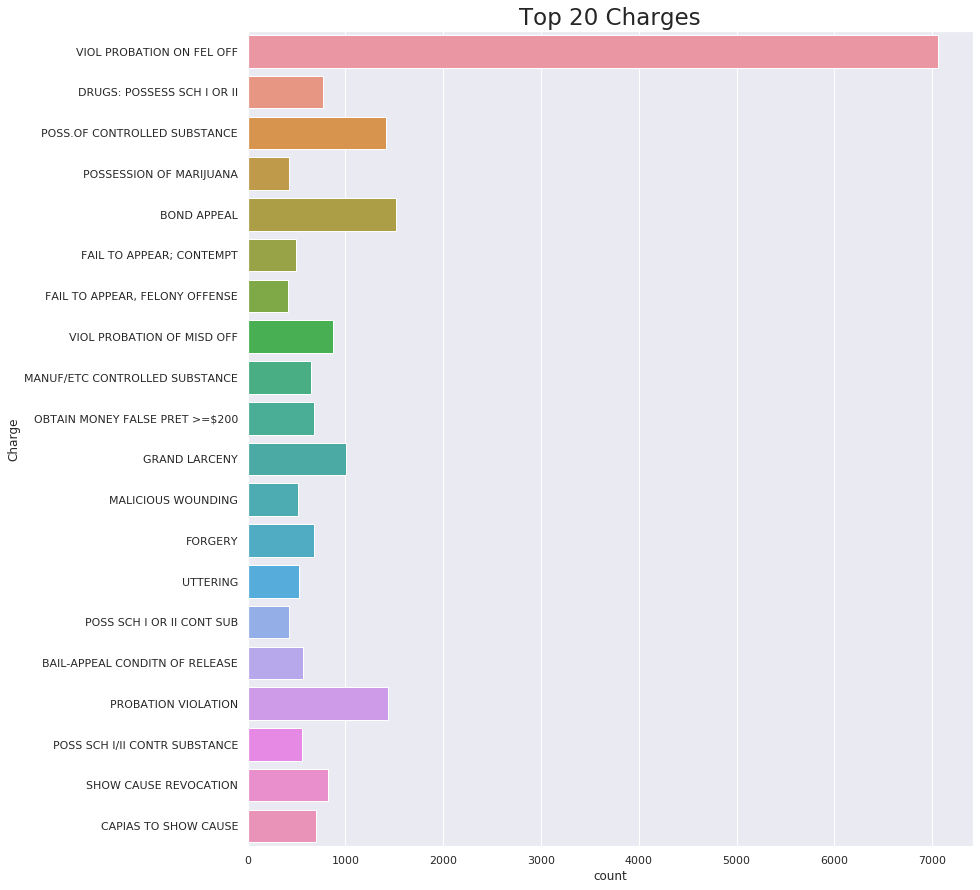

In [21]:
# just counts, not broken up 
sns.set(rc={'figure.figsize':(13,15)})
sns.set(style="darkgrid")
ax = sns.countplot(y="Charge", 
                   data=circuit)
ax.set_title('Top 20 Charges', fontsize = 23)
# https://seaborn.pydata.org/generated/seaborn.countplot.html

In [22]:
dict(circuit.Charge.value_counts(dropna=False).head(20))

{'VIOL PROBATION ON FEL OFF': 7063,
 'BOND APPEAL': 1517,
 'PROBATION VIOLATION': 1439,
 'POSS.OF CONTROLLED SUBSTANCE': 1417,
 'GRAND LARCENY': 1011,
 'VIOL PROBATION OF MISD OFF': 875,
 'SHOW CAUSE REVOCATION': 820,
 'DRUGS: POSSESS SCH I OR II': 768,
 'CAPIAS TO SHOW CAUSE': 699,
 'OBTAIN MONEY FALSE PRET >=$200': 681,
 'FORGERY': 679,
 'MANUF/ETC CONTROLLED SUBSTANCE': 650,
 'BAIL-APPEAL CONDITN OF RELEASE': 569,
 'POSS SCH I/II CONTR SUBSTANCE': 558,
 'UTTERING': 526,
 'MALICIOUS WOUNDING': 516,
 'FAIL TO APPEAR; CONTEMPT': 493,
 'POSS SCH I OR II CONT SUB': 424,
 'POSSESSION OF MARIJUANA': 420,
 'FAIL TO APPEAR, FELONY OFFENSE': 416}

#### Broken up by Racial Category (Black + White Only)

In [23]:
circuit_bar_1 = circuit[circuit['Race'].isin(['Black', 'White'])]

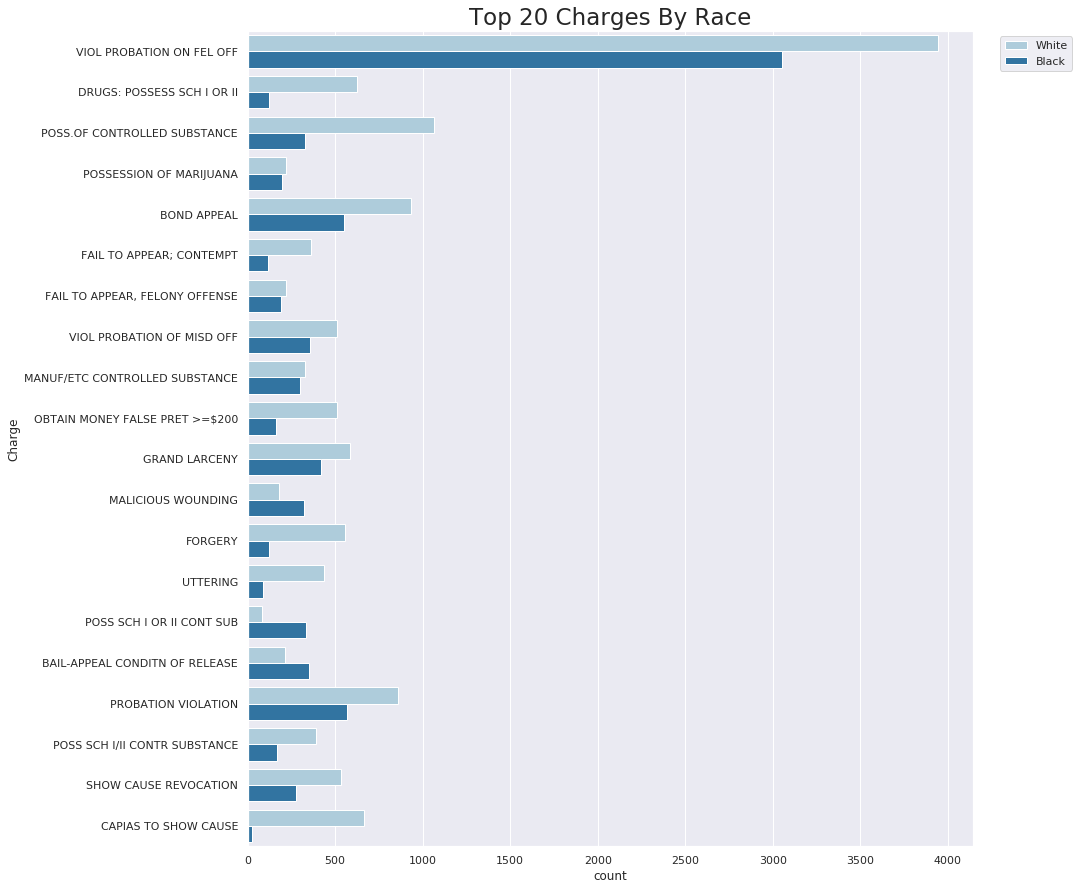

In [24]:
sns.set(rc={'figure.figsize':(13,15)})
sns.set(style="darkgrid")
sns.set_palette("Paired")
ax = sns.countplot(y="Charge", 
                   data=circuit_bar_1, 
                   hue="Race")
ax.set_title('Top 20 Charges By Race', fontsize = 23)
ax.legend(bbox_to_anchor= (1.03, 1) )
# https://seaborn.pydata.org/generated/seaborn.countplot.html

#### Broken up by Racial Category (Everyone Else)
- The order of magnitude is so large that these values don't show up on the above graph
- Above graph has x-axis of 4,000, below graph only has x-axis going to 25

In [25]:
circuit_bar_2 = circuit[-circuit['Race'].isin(['Black', 'White'])]

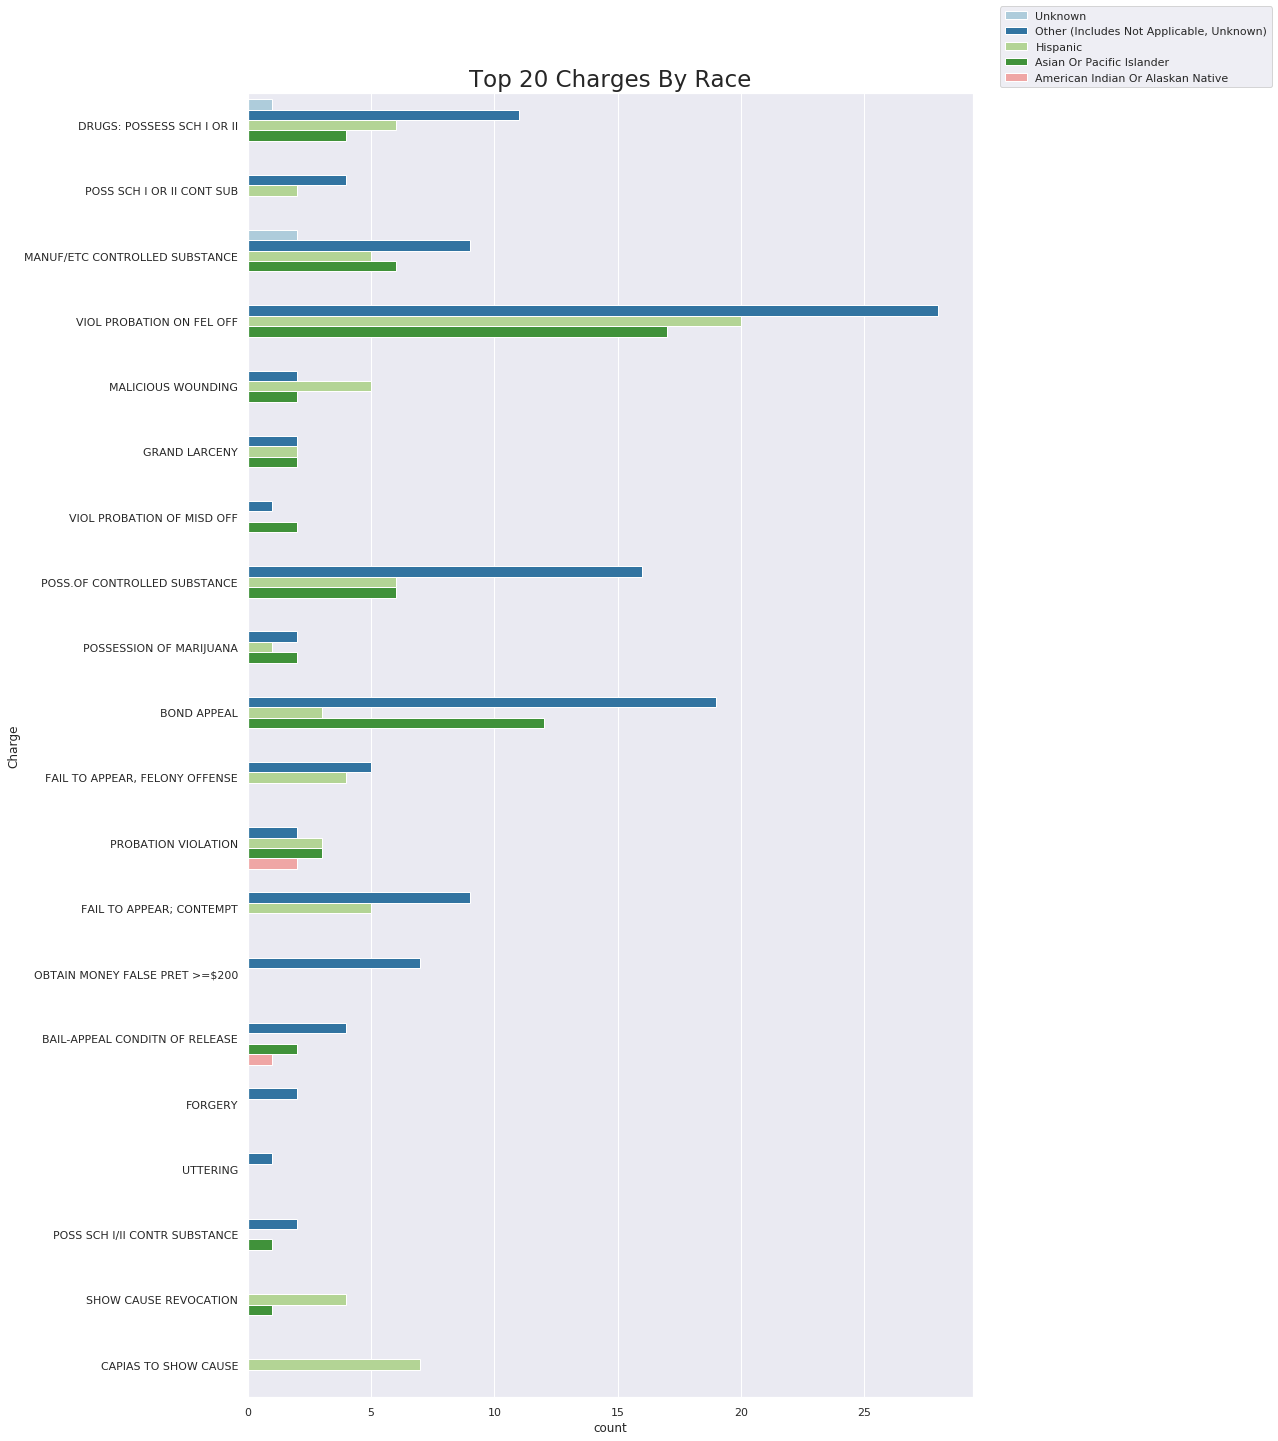

In [26]:
sns.set(rc={'figure.figsize':(13,24)})
sns.set(style="darkgrid")
sns.set_palette("Paired")
ax = sns.countplot(y="Charge", 
                   data=circuit_bar_2, 
                   hue="Race")
ax.set_title('Top 20 Charges By Race', fontsize = 23)
ax.legend(bbox_to_anchor= (1.03, 1) )
# https://seaborn.pydata.org/generated/seaborn.countplot.html